* We have 4 models for predicting Airbnb price per night, which are Linear Regression, XGboost, Lasso, Decision Tree.

* The best model is XGBoost.

In [52]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error 
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_property = pd.read_csv('https://data-analytics-airbnb.s3.us-east-2.amazonaws.com/Data/property.csv')

In [3]:
df_price = pd.read_csv("https://data-analytics-airbnb.s3.us-east-2.amazonaws.com/Data/price.csv")

In [4]:
df_host = pd.read_csv("https://data-analytics-airbnb.s3.us-east-2.amazonaws.com/Data/host.csv")

In [5]:
df_amenity = pd.read_csv("https://data-analytics-airbnb.s3.us-east-2.amazonaws.com/Data/amenity.csv")

In [6]:
df_neighborhood = pd.read_csv("https://data-analytics-airbnb.s3.us-east-2.amazonaws.com/Data/neighborhood.csv")

In [7]:
df_amenity.columns

Index(['amenity_id', 'wireless_Internet', 'air_conditioning', 'pool',
       'self_check_in', 'private_entrance', 'breakfast',
       'free_parking_on_premises', 'tv', 'gym', 'hot_tub', 'indoor_fireplace',
       'heating', 'family_kid_friendly', 'washer', 'dryer', 'hangers', 'iron',
       'shampoo', 'hair_dryer', 'high_chair', 'crib',
       'carbon_monoxide_detector', 'smoke_detector',
       'babysitter_recommendations', 'pets_allowed', 'first_aid_kit'],
      dtype='object')

In [8]:
property_amenity = pd.merge(df_amenity, df_property, on="amenity_id")

In [9]:
property_price = pd.merge(property_amenity, df_price, on="price_id")

In [11]:
property_host = pd.merge(property_price, df_host, on="host_id")

In [12]:
df = pd.merge(property_host, df_neighborhood, on="neighborhood_id")

In [13]:
df.columns

Index(['amenity_id', 'wireless_Internet', 'air_conditioning', 'pool',
       'self_check_in', 'private_entrance', 'breakfast',
       'free_parking_on_premises', 'tv', 'gym', 'hot_tub', 'indoor_fireplace',
       'heating', 'family_kid_friendly', 'washer', 'dryer', 'hangers', 'iron',
       'shampoo', 'hair_dryer', 'high_chair', 'crib',
       'carbon_monoxide_detector', 'smoke_detector',
       'babysitter_recommendations', 'pets_allowed', 'first_aid_kit',
       'property_id', 'host_id', 'neighborhood_id', 'price_id',
       'availability_id', 'listing_name', 'listing_description',
       'property_type', 'bedrooms', 'bathrooms', 'accommodates', 'beds',
       'bed_type', 'room_type', 'minimum_nights', 'maximum_nights',
       'extra_people_cost', 'daily_price', 'weekly_price', 'monthly_price',
       'cleaning_fee', 'security_deposit', 'host_url', 'host_name',
       'host_since', 'host_is_superhost', 'host_response_time',
       'host_acceptance_rate', 'latitude', 'longitude', 'nei

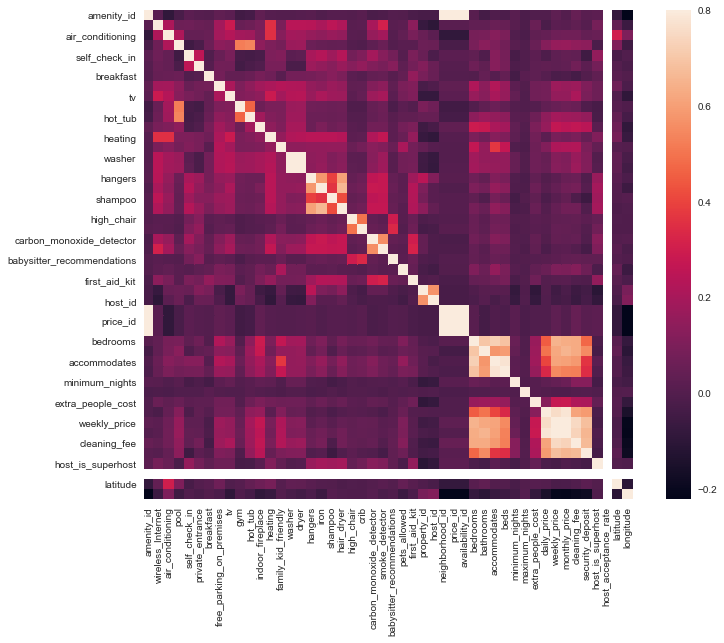

In [14]:
corr = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);

In [15]:
corr[['daily_price','weekly_price']].sort_values(by="daily_price", ascending=False)

,daily_price,weekly_price
daily_price,1.000000,0.758278
monthly_price,0.783744,0.970306
weekly_price,0.758278,1.000000
cleaning_fee,0.615480,0.750791
security_deposit,0.589963,0.682695
bathrooms,0.497131,0.621590
bedrooms,0.449239,0.648975
accommodates,0.401630,0.614077
beds,0.331007,0.551508
indoor_fireplace,0.157454,0.267998


In [16]:
property_price = df[[ 'latitude', 'longitude', 'extra_people_cost', 'minimum_nights', 'indoor_fireplace', 
                     'bedrooms', 'bathrooms', 'accommodates', 'beds',  'hot_tub', 'room_type', 'bed_type',
                    'security_deposit', 'cleaning_fee', 'free_parking_on_premises', 'pool', 'tv', 'indoor_fireplace', 'pets_allowed',
                     'indoor_fireplace', 'daily_price']]

In [17]:
property_price

,latitude,longitude,extra_people_cost,minimum_nights,indoor_fireplace,bedrooms,bathrooms,accommodates,beds,hot_tub,...,bed_type,security_deposit,cleaning_fee,free_parking_on_premises,pool,tv,indoor_fireplace,pets_allowed,indoor_fireplace,daily_price
0,34.530350,-118.227088,0.0,1,1,5.0,7.0,10,5.0,1,...,Real Bed,2000.0,200.0,1,1,0,1,0,1,3000.0
1,34.485431,-118.125380,0.0,1,0,1.0,1.0,2,1.0,0,...,Real Bed,NaN,NaN,0,0,0,0,0,0,50.0
2,34.510130,-118.212407,10.0,1,0,1.0,1.0,2,1.0,0,...,Real Bed,NaN,NaN,1,0,0,0,1,0,55.0
3,34.515486,-118.230742,0.0,1,1,1.0,1.0,6,3.0,1,...,Real Bed,NaN,35.0,1,1,1,1,1,1,150.0
4,34.031419,-118.299016,10.0,1,0,1.0,1.0,1,1.0,0,...,Real Bed,NaN,5.0,1,0,0,0,0,0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31248,33.353834,-118.329479,0.0,2,0,2.0,2.0,5,2.0,0,...,Real Bed,NaN,75.0,1,1,1,0,0,0,425.0
31249,33.930022,-117.974940,15.0,1,1,1.0,1.0,2,1.0,0,...,Real Bed,NaN,15.0,0,0,1,1,0,1,75.0
31250,34.036676,-118.650505,0.0,5,0,5.0,5.0,10,5.0,0,...,Real Bed,1000.0,NaN,1,0,1,0,0,0,500.0
31251,33.944261,-117.927134,17.0,2,1,2.0,1.0,4,2.0,0,...,Real Bed,NaN,NaN,1,0,1,1,1,1,65.0


In [18]:
property_price.room_type.value_counts(normalize=True)

Entire home/apt    0.575785
Private room       0.371900
Shared room        0.052315
Name: room_type, dtype: float64

In [19]:
property_price['room_type'] = property_price['room_type'].str.replace("Entire home/apt", '1')
property_price['room_type'] = property_price['room_type'].str.replace("Private room", '2')
property_price['room_type'] = property_price['room_type'].str.replace("Shared room", '3')

In [20]:
property_price.bed_type.value_counts(normalize=True)

Real Bed         0.972739
Futon            0.010015
Pull-out Sofa    0.006463
Airbed           0.006207
Couch            0.004576
Name: bed_type, dtype: float64

In [21]:
property_price['bed_type'] = property_price['bed_type'].str.replace("Real Bed", '1')
property_price['bed_type'] = property_price['bed_type'].str.replace("Futon", '2')
property_price['bed_type'] = property_price['bed_type'].str.replace("Pull-out Sofa", '3')
property_price['bed_type'] = property_price['bed_type'].str.replace("Airbed", '4')
property_price['bed_type'] = property_price['bed_type'].str.replace("Couch", '5')

In [22]:
property_price.isna().sum()

latitude                        0
longitude                       0
extra_people_cost               0
minimum_nights                  0
indoor_fireplace                0
bedrooms                       35
bathrooms                      97
accommodates                    0
beds                           59
hot_tub                         0
room_type                       0
bed_type                        0
security_deposit            14397
cleaning_fee                 6974
free_parking_on_premises        0
pool                            0
tv                              0
indoor_fireplace                0
pets_allowed                    0
indoor_fireplace                0
daily_price                     0
dtype: int64

In [23]:
# drop columns with too many Nan's
#property_price.drop(columns=['security_deposit'], inplace=True)

In [24]:
# drop rows with NaN's in bathrooms and bedrooms
property_price = property_price.dropna(subset=['security_deposit', 'cleaning_fee', 'bedrooms', 'bathrooms', 'beds'])

In [25]:
property_price.shape

(15779, 21)

In [26]:
property_price['daily_price'].describe()

count    15779.000000
mean       214.194499
std        390.538572
min         12.000000
25%         86.000000
50%        128.000000
75%        200.000000
max      10000.000000
Name: daily_price, dtype: float64

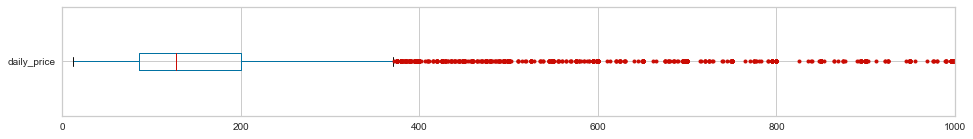

In [27]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
property_price['daily_price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

In [28]:
property_price = property_price[(property_price.daily_price < 400)]

In [29]:
property_price['daily_price'].describe()

count    14377.000000
mean       140.039994
std         79.426841
min         12.000000
25%         82.000000
50%        120.000000
75%        180.000000
max        399.000000
Name: daily_price, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000269A5D47B88>,
      dtype=object)

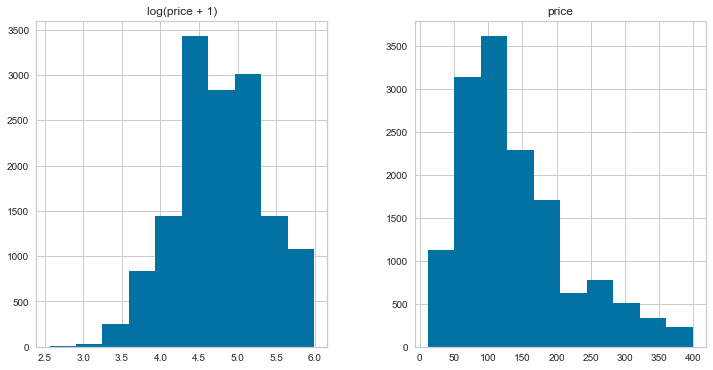

In [30]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":property_price["daily_price"], "log(price + 1)":np.log1p(property_price["daily_price"])})
prices.hist()

In [31]:
X = property_price.loc[:, property_price.columns != 'daily_price']

In [32]:
y = property_price.loc[:, 'daily_price']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [34]:
y_train.describe()

count    11501.000000
mean       140.178941
std         79.402518
min         16.000000
25%         83.000000
50%        120.000000
75%        180.000000
max        399.000000
Name: daily_price, dtype: float64

## Linear Regression

In [35]:
# import Linear Regression
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
# making predictions
y_pred_test = linreg.predict(X_test)

In [37]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 48.9048


In [38]:
r2 = r2_score(y_test, y_pred_test)
print(f"r2: {round(r2, 4)}")

r2: 0.6218


## XGboost

In [39]:
booster = xgb.XGBRegressor()

In [40]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [41]:
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

In [42]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 42.6997


In [43]:
r2 = r2_score(y_test, y_pred_test)
print(f"r2: {round(r2, 4)}")

r2: 0.7117


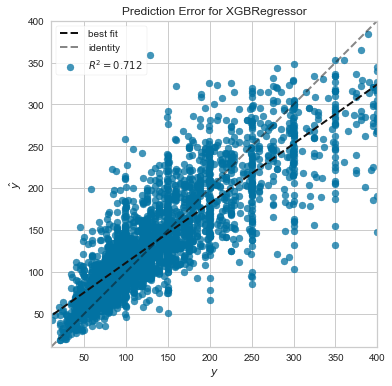

In [44]:
visualizer = PredictionError(booster)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

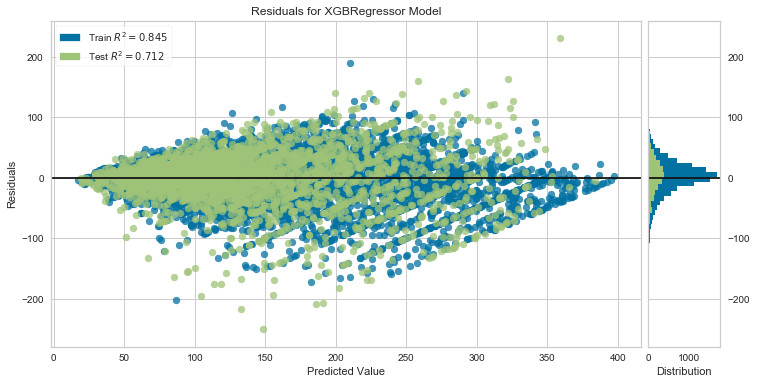

In [46]:
visualizer = ResidualsPlot(booster)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## Lasso

In [47]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)
y_pred = model_lasso.predict(X_test)
predictions = [round(value) for value in y_pred]
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE for Lasso: %f" % (rmse))

RMSE for Lasso: 48.890720


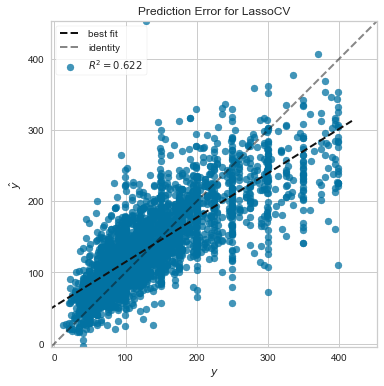

In [48]:
visualizer = PredictionError(model_lasso)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

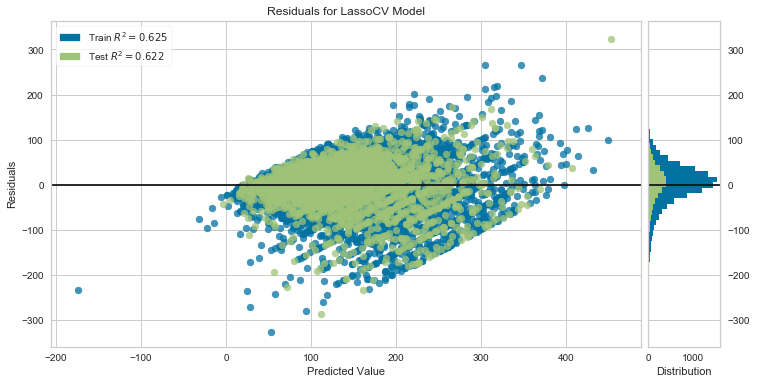

In [49]:
visualizer = ResidualsPlot(model_lasso)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## Decision Tree

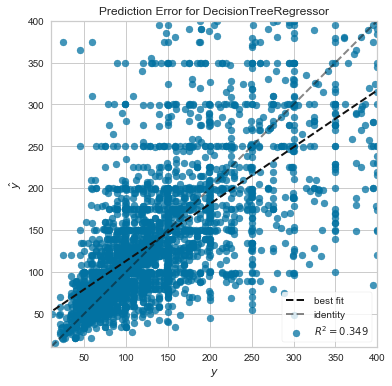

In [50]:
dtree = DecisionTreeRegressor(random_state=0)
visualizer = PredictionError(dtree)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

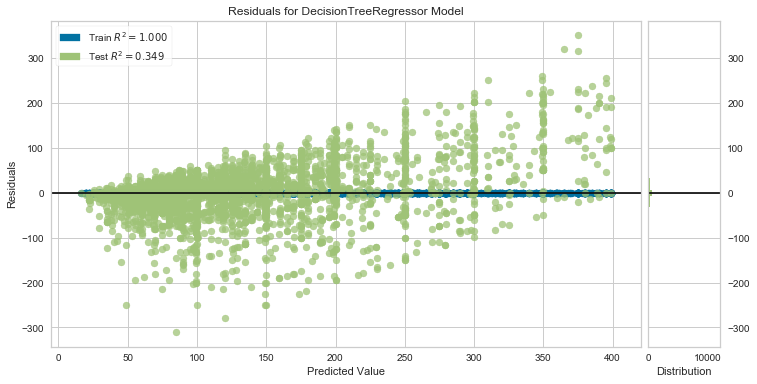

In [51]:
visualizer = ResidualsPlot(dtree)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()